In [1]:
import sys, os, pickle
sys.path.append('/scratch/oem214/vanilla-rtrl/')
from cluster import *
from continual_learning import *
from core import *
from dynamics import *
from functions import *
from gen_data import *
from learning_algorithms import *
from optimizers import *
from plotting import *
from wrappers import *

In [21]:
### --- SET UP ALL CONFIGS --- ###
from itertools import product
n_seeds = 3
macro_configs = config_generator(sigma=[0.001, 0.003, 0.01, 0.03, 0.1],
                                 p=[0.01, 0.03, 0.1, 0.3])
micro_configs = tuple(product(macro_configs, list(range(n_seeds))))

### --- SELECT PARTICULAR CONFIG --- ###
try:
    i_job = int(os.environ['SLURM_ARRAY_TASK_ID']) - 1
except KeyError:
    i_job = 0
params, i_seed = micro_configs[i_job]
i_config = i_job//n_seeds

new_random_seed_per_condition = True
if new_random_seed_per_condition:
    np.random.seed(i_job)
else: #Match random seeds across conditions
    np.random.seed(i_seed)

In [3]:
#task = Flip_Flop_Task(3, 0.05, input_magnitudes=None)
#task = Add_Task(3, 5, deterministic=True, tau_task=1)
#task = Sine_Wave(0.05, )
task = Delay_Nonmatch_Task(delay_duration=3)
N_train = 500000
N_test = 5000
checkpoint_interval = None
sigma = 0

data = task.gen_data(N_train, N_test)

n_in = task.n_in
n_hidden = 64

n_out = task.n_out
W_in  = np.random.normal(0, np.sqrt(1/(n_in)), (n_hidden, n_in))
W_rec = np.random.normal(0, np.sqrt(1/n_hidden), (n_hidden, n_hidden))
W_out = np.random.normal(0, np.sqrt(1/(n_hidden)), (n_out, n_hidden))

b_rec = np.zeros(n_hidden)
b_out = np.zeros(n_out)

alpha = 0.2
sigma = 0

rnn = RNN(W_in, W_rec, W_out, b_rec, b_out,
          activation=tanh,
          alpha=alpha,
          output=identity,
          loss=mean_squared_error)

#learn_alg = REINFORCE(rnn, sigma=params['sigma'], decay=params['decay'], loss_decay=params['loss_decay'])
#learn_alg = REINFORCE(rnn, sigma=params['sigma'], decay=1, loss_decay=0.01)
#if params['learn_alg'] == 'Miconi_REIN':
learn_alg = Miconi_REINFORCE(rnn, sigma=params['sigma'], p=params['p'], n_trial_types=4,
                             h_avg_decay=0.7,
                             loss_decay=0.01,
                             reset_h_avg=False)
#if params['learn_alg'] == 'REIN':
#learn_alg = REINFORCE(rnn, sigma=sigma)
#learn_alg = Only_Output_Weights(rnn)
#optimizer = SGD_Momentum(lr=0.001, mu=0.6)
optimizer = Stochastic_Gradient_Descent(lr=0.001)

#monitors = ['learn_alg.h_avg', 'rnn.h', 'learn_alg.e_trace-norm', 'learn_alg.e_immediate-norm']
monitors = []

sim = Simulation(rnn,
                 time_steps_per_trial=task.time_steps_per_trial,
                 trial_mask=task.trial_mask,
                 reset_sigma=0)
sim.run(data, learn_alg=learn_alg, optimizer=optimizer,
        sigma=sigma,
        monitors=monitors,
        verbose=True,
        report_accuracy=False,
        report_loss=True,
        checkpoint_interval=checkpoint_interval)

Progress: 10.0% complete 
Time Elapsed: 3.6s 
Test loss: 0.028189979892172295 

Progress: 20.0% complete 
Time Elapsed: 7.3s 
Test loss: 0.026971174039209754 

Progress: 30.0% complete 
Time Elapsed: 11.1s 
Test loss: 0.026353938685183043 

Progress: 40.0% complete 
Time Elapsed: 14.9s 
Test loss: 0.02583880756807005 

Progress: 50.0% complete 
Time Elapsed: 18.6s 
Test loss: 0.0255641116205335 

Progress: 60.0% complete 
Time Elapsed: 22.4s 
Test loss: 0.025881829553885148 

Progress: 70.0% complete 
Time Elapsed: 26.2s 
Test loss: 0.025377353915797367 

Progress: 80.0% complete 
Time Elapsed: 29.9s 
Test loss: 0.025392142071893983 

Progress: 90.0% complete 
Time Elapsed: 33.7s 
Test loss: 0.02525329044204276 



In [ ]:
#plot_output_from_checkpoint(sim.checkpoints[max(sim.checkpoints.keys())], data, xlim=50,
#                            time_steps_per_trial=task.time_steps_per_trial,
#                            trial_mask=task.trial_mask,
#                            reset_sigma=0)

In [4]:
test_sim = sim.get_test_sim()
test_sim.run(data, mode='test', monitors=['rnn.loss_'], verbose=False)
processed_data = np.mean(test_sim.mons['rnn.loss_'])

In [ ]:
### --- SAVE RESULTS -- ###
result = {'sim': sim, 'i_seed': i_seed, 'task': task,
          'config': params, 'i_config': i_config, 'i_job': i_job}
try:
    result['processed_data'] = processed_data
except NameError:
    pass
    
try:
    save_dir = os.environ['SAVEDIR']
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    save_path = os.path.join(save_dir, 'result_{}'.format(i_job))

    with open(save_path, 'wb') as f:
        pickle.dump(result, f)
except KeyError:
    pass

In [22]:
###Truncate file above
file_name = 'reinforce'
job_name = 'separate_loss_grid2'
get_ipython().run_cell_magic('javascript', '', 'IPython.notebook.save_notebook()')
get_ipython().system('jupyter nbconvert --to script --no-prompt {}.ipynb'.format(file_name))
get_ipython().system('awk "/###Truncate/ {{exit}} {{print}}" {}.py'.format(file_name))
get_ipython().system('sed -i "/###Truncate/Q" {}.py'.format(file_name))
get_ipython().system('mv {}.py ../cluster_main_scripts/{}.py'.format(file_name, job_name))

<IPython.core.display.Javascript object>

[NbConvertApp] Converting notebook reinforce.ipynb to script
[NbConvertApp] Writing 6229 bytes to reinforce.py
awk: 1: unexpected character '.'


In [23]:
###Submit job to cluster
n_jobs = len(micro_configs)
write_job_file(job_name, py_file_name='{}.py'.format(job_name))
job_id_1 = submit_job('../job_scripts/{}.s'.format(job_name), n_jobs)

sending incremental file list

sent 11,566 bytes  received 45 bytes  23,222.00 bytes/sec
total size is 1,324,268  speedup is 114.05


In [24]:
job_name = 'separate_loss_grid2'

In [30]:
###Get job status
get_ipython().system('squeue -u oem214')

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
          10315272        cm  jupyter   oem214  R    3:11:55      1 cm38


In [31]:
configs_array, results_array, key_order, sim_dict = unpack_processed_data('../job_scripts/{}.s'.format(job_name))

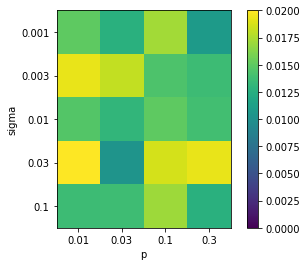

In [38]:
fig = plot_2d_array_of_config_results(configs_array, results_array, key_order,
                                      log_scale=False, tick_rounding=5, vmin=0, vmax=0.02)

In [39]:
figs_path = 'figs/miconi_task/'
fig.savefig(os.path.join(figs_path, 'grid_{}.pdf'.format(job_name)), format='pdf')

In [32]:
configs_array

{'sigma': [0.001, 0.003, 0.01, 0.03, 0.1],
 'p': [0.01, 0.03, 0.1, 0.3],
 'i_seed': [0, 1, 2]}

In [ ]:
fig = plot_3d_or_4d_array_of_config_results(configs_array, results_array, key_order, tick_rounding=5,
                                            vmin=0, vmax=0.2)

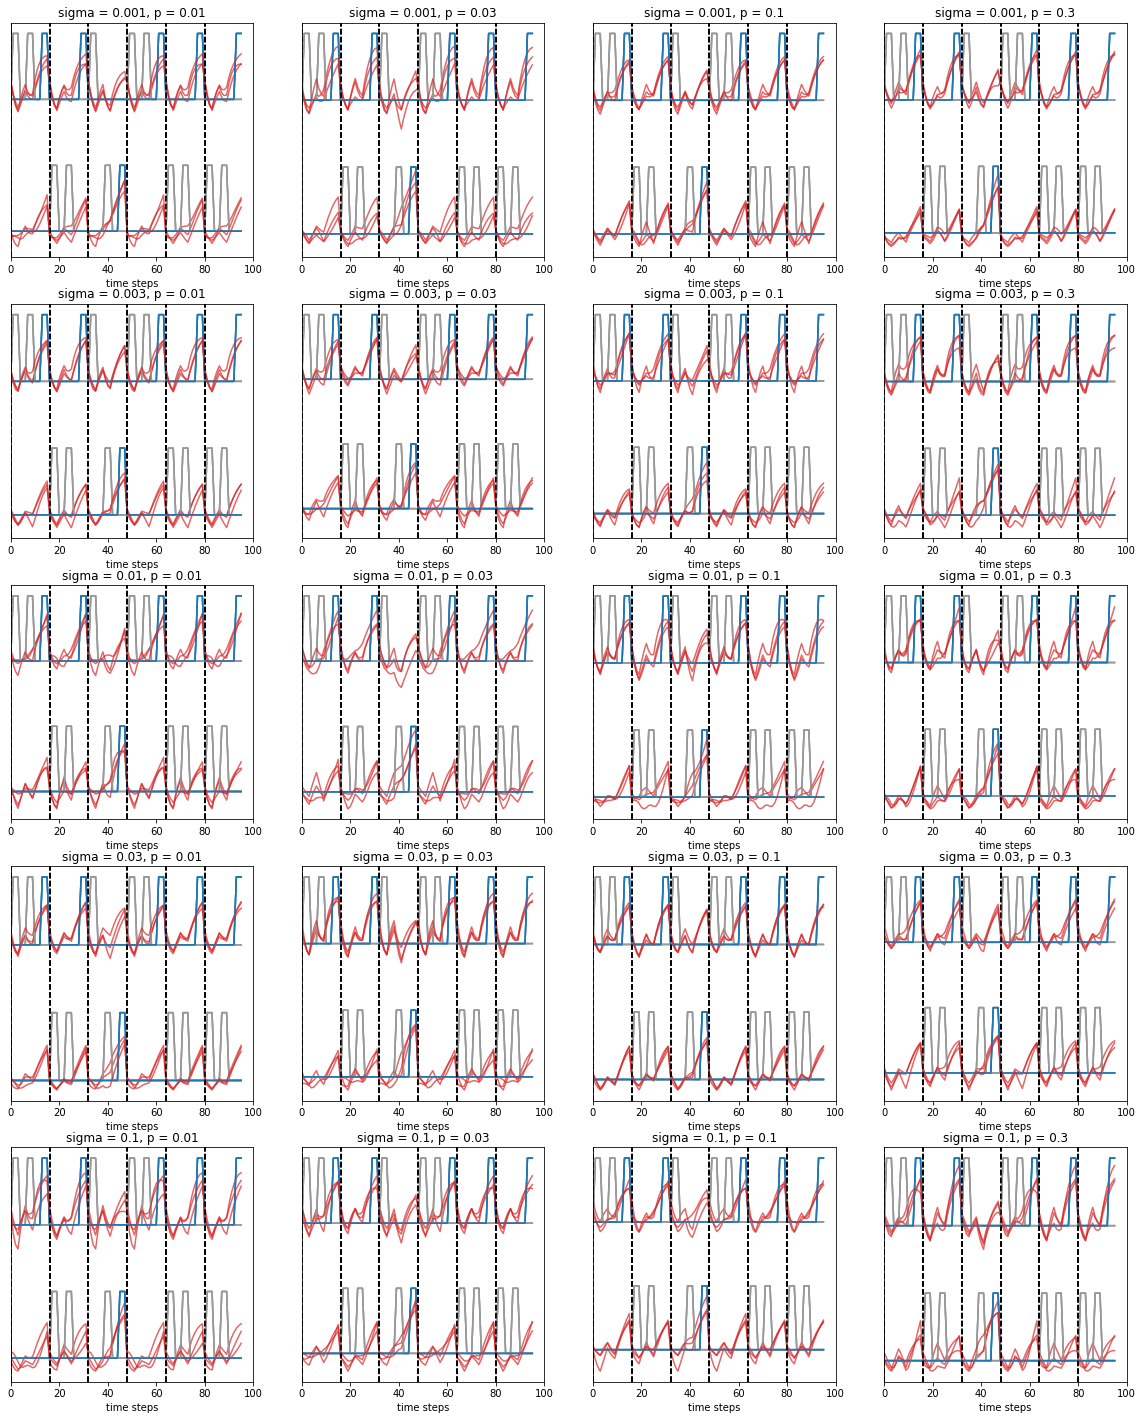

In [36]:
data = task.gen_data(0, 100)
fig = plot_1d_or_2d_array_of_config_examples(configs_array, results_array,
                                             key_order, sim_dict, data,
                                             task_dict=None, N_task_data=None,
                                             xlim=100)

In [37]:
figs_path = 'figs/miconi_task/'
fig.savefig(os.path.join(figs_path, 'examples_{}.pdf'.format(job_name)), format='pdf')

In [ ]:
np.where(results_array.mean(-1) < 0.45)

In [ ]:
key_order

In [ ]:
sim_dict.keys()

In [ ]:
for i_alpha, alpha in enumerate([0.01, 0.05, 0.1, 0.2, 0.5, 0.8]):
    sim = sim_dict['{}_0'.format(alpha)]
    fig = plot_output_from_checkpoint(sim.checkpoints[max(sim.checkpoints.keys())], data)
    plt.title('alpha = {}'.format(alpha))
    fig.savefig(os.path.join(figs_path, 'best_config_alpha={}.pdf'.format(i_alpha)), format='pdf')

In [ ]:
task = Flip_Flop_Task(3, 0.05, input_magnitudes=None)
N_train = 200000
N_test = 5000
checkpoint_interval = None
sigma = 0

data = task.gen_data(N_train, N_test)

In [ ]:
from scipy.spatial import distance

In [ ]:
import numpy as np
help(np.vstack)

In [ ]:
def factorial_(n):
    
    if n = 1:
        return 1
    else:
        return factorial_(n_1) * n

In [ ]:
fac